In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Activation
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats.mstats import winsorize
import seaborn as sns
import re
import gc
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [2]:
df = pd.read_csv('tcc.csv')
df.head()
telco = df.copy()

In [3]:
def null_values(df, rate=0):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv['Percentage (%)']>rate].sort_values('Percentage (%)', ascending=False)

In [4]:
null_values(telco)

,Missing_Records,Percentage (%)
numbcars,49366,49.366
dwllsize,38308,38.308
HHstatin,37923,37.923
ownrent,33706,33.706
dwlltype,31909,31.909
lor,30190,30.190
income,25436,25.436
adults,23019,23.019
infobase,22079,22.079
hnd_webcap,10189,10.189


In [5]:
telco = telco.drop('Customer_ID', axis=1)

In [6]:
cat_cols = [col for col in telco.columns if telco[col].dtype=='object']

In [7]:

def column_details(regex, df):
  # We will focus on each column in detail
  # Uniqe Values, DTYPE, NUNIQUE, NULL_RATE
  global columns
  columns=[col for col in df.columns if re.search(regex, col)]

  from colorama import Fore, Back, Style

  print('Unique Values of the Features:\nfeature: DTYPE, NUNIQUE, NULL_RATE\n')
  for i in df[columns]:
      color = Fore.RED if df[i].dtype =='float64' else Fore.BLUE if df[i].dtype =='int64' else Fore.GREEN
      print(f'{i}: {color} {df[i].dtype}, {df[i].nunique()}, %{round(df[i].isna().sum()/len(df[i])*100,2)}\n{Style.RESET_ALL}{pd.Series(df[i].unique()).sort_values().values}\n')
      

In [8]:
columns=[]
column_details(regex='', df=telco[cat_cols])

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

new_cell:  object, 3, %0.0
['N' 'U' 'Y']

crclscod:  object, 54, %0.0
['A' 'A2' 'A3' 'AA' 'B' 'B2' 'BA' 'C' 'C2' 'C5' 'CA' 'CC' 'CY' 'D' 'D2'
 'D4' 'D5' 'DA' 'E' 'E2' 'E4' 'EA' 'EC' 'EF' 'EM' 'G' 'GA' 'GY' 'H' 'I'
 'IF' 'J' 'JF' 'K' 'L' 'M' 'O' 'P1' 'S' 'TP' 'U' 'U1' 'V' 'V1' 'W' 'Y' 'Z'
 'Z1' 'Z2' 'Z4' 'Z5' 'ZA' 'ZF' 'ZY']

asl_flag:  object, 2, %0.0
['N' 'Y']

prizm_social_one:  object, 5, %7.39
['C' 'R' 'S' 'T' 'U' nan]

area:  object, 19, %0.04
['ATLANTIC SOUTH AREA' 'CALIFORNIA NORTH AREA' 'CENTRAL/SOUTH TEXAS AREA'
 'CHICAGO AREA' 'DALLAS AREA' 'DC/MARYLAND/VIRGINIA AREA'
 'GREAT LAKES AREA' 'HOUSTON AREA' 'LOS ANGELES AREA' 'MIDWEST AREA'
 'NEW ENGLAND AREA' 'NEW YORK CITY AREA' 'NORTH FLORIDA AREA'
 'NORTHWEST/ROCKY MOUNTAIN AREA' 'OHIO AREA' 'PHILADELPHIA AREA'
 'SOUTH FLORIDA AREA' 'SOUTHWEST AREA' 'TENNESSEE AREA' nan]

dualband:  object, 4, %0.0
['N' 'T' 'U' 'Y' nan]

refurb_new:  object, 2, %0.0
['N' 'R' na

In [9]:
cols_FE = ['vce_blk_rate','vce_drp_rate','dat_blk_rate','dat_drp_rate','vce_cmpt_rate','dat_cmpt_rate','tot_cmpt_rate',
          'tot_drp_blk_rate','vce_dat_ratio','diff_3mon_overall_mou','diff_3mon_overall_qty','diff_3mon_overall_rev',
          'diff_6mon_overall_mou','diff_6mon_overall_qty','diff_6mon_overall_rev']

In [10]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Median = df.quantile(0.5)
    Mean = df.mean()
    Mode = df.mode().loc[0]
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max', 'Mean', 'Median','Mode']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max, Mean, Median, Mode], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

In [11]:
num_cols = [col for col in telco.columns if telco[col].dtype!='object']
summary(telco[num_cols])

Data shape: (100000, 78)
___________________________
Data Types:
float64    69
int64       9
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max,Mean,Median,Mode
actvsubs,int64,100000,12,0,0.000000,53.000000,1.358960,1.000000,1.00000
adjmou,float64,100000,23455,0,0.000000,232855.100000,7546.314699,5102.500000,0.00000
adjqty,int64,100000,12185,0,0.000000,98705.000000,2836.366920,1789.000000,837.00000
adjrev,float64,100000,75274,0,2.400000,27071.300000,960.111529,737.760000,302.60000
adults,float64,76981,7,23019,1.000000,6.000000,2.530326,2.000000,2.00000
attempt_Mean,float64,100000,2918,0,0.000000,2289.000000,145.752225,101.000000,0.00000
avg3mou,int64,100000,3108,0,0.000000,7716.000000,519.641210,358.000000,0.00000
avg3qty,int64,100000,1438,0,0.000000,3909.000000,180.337320,125.000000,0.00000
avg3rev,int64,100000,507,0,1.000000,1593.000000,59.193330,48.000000,30.00000
avg6mou,float64,97161,2942,2839,0.000000,7217.000000,509.634576,363.000000,0.00000


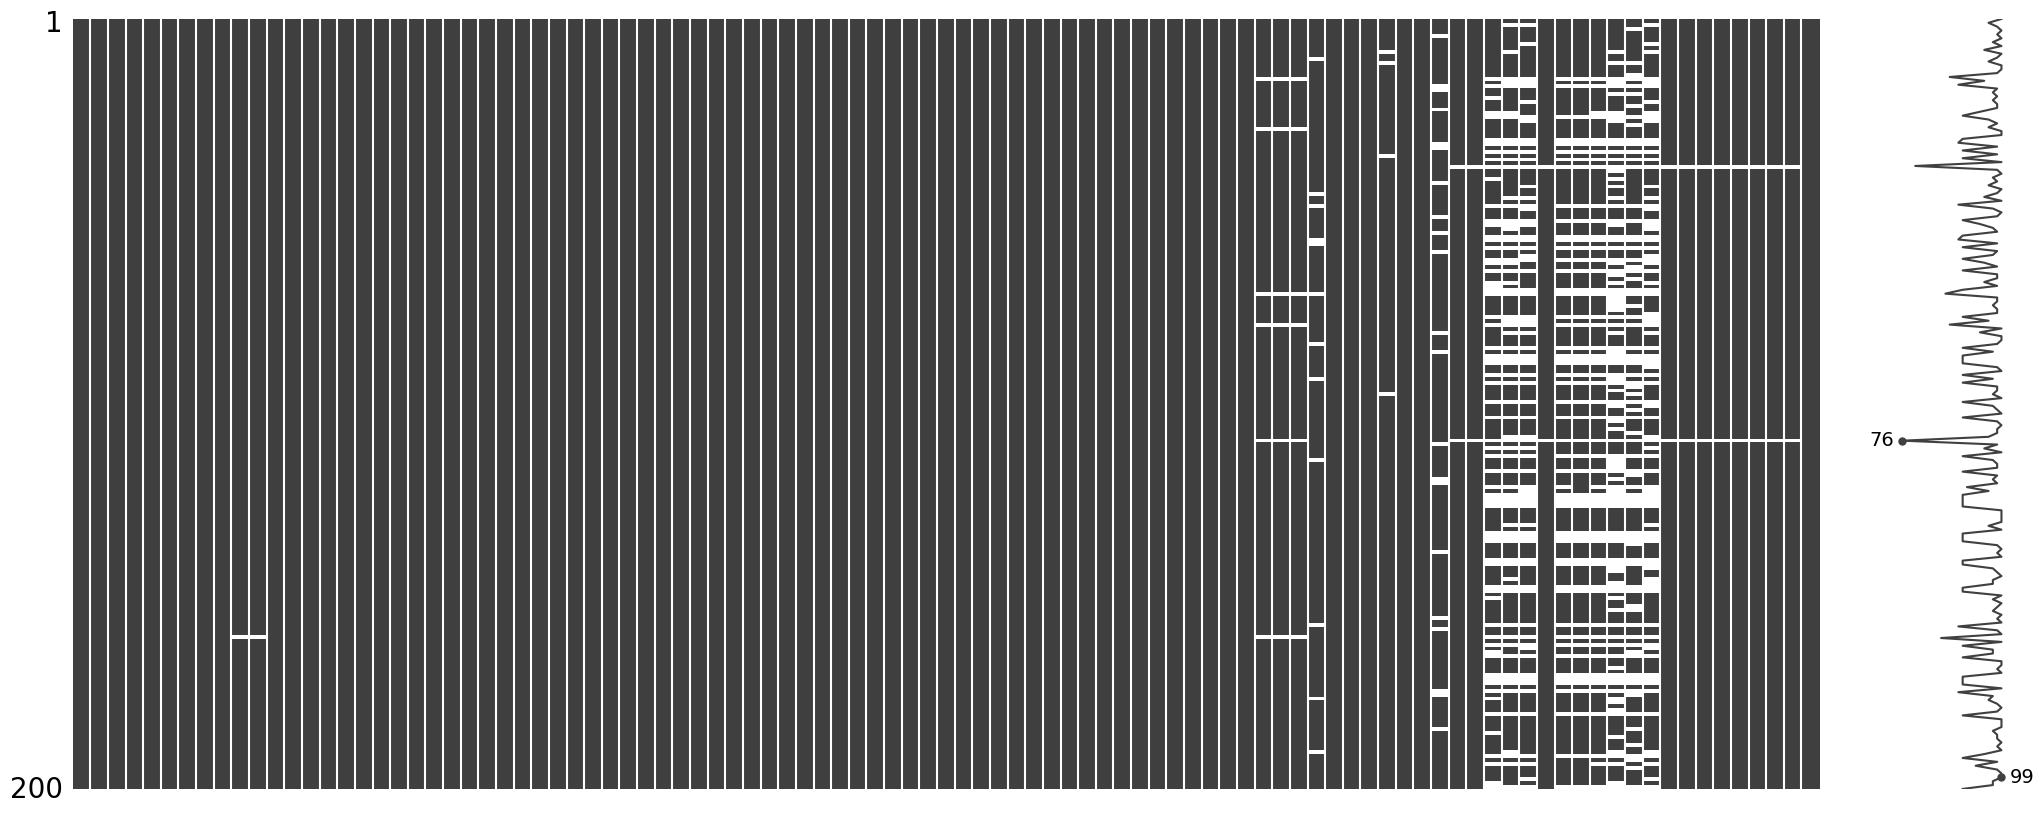

In [12]:
import missingno as msno
msno.matrix(telco.sample(200));

In [13]:
# Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
#                 print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return drops

In [14]:
drop_col = remove_collinear_features(telco[num_cols], 0.9)
print(drop_col)

{'opk_dat_Mean', 'ovrrev_Mean', 'avg3rev', 'avg3mou', 'peak_dat_Mean', 'cc_mou_Mean', 'attempt_Mean', 'mou_opkd_Mean', 'adjmou', 'complete_Mean', 'adjrev', 'adjqty', 'comp_vce_Mean', 'vceovr_Mean', 'avg6qty', 'totmou', 'avg3qty', 'avg6mou', 'comp_dat_Mean', 'avg6rev', 'peak_vce_Mean', 'inonemin_Mean'}


In [15]:
telco = telco.drop(drop_col, axis=1)

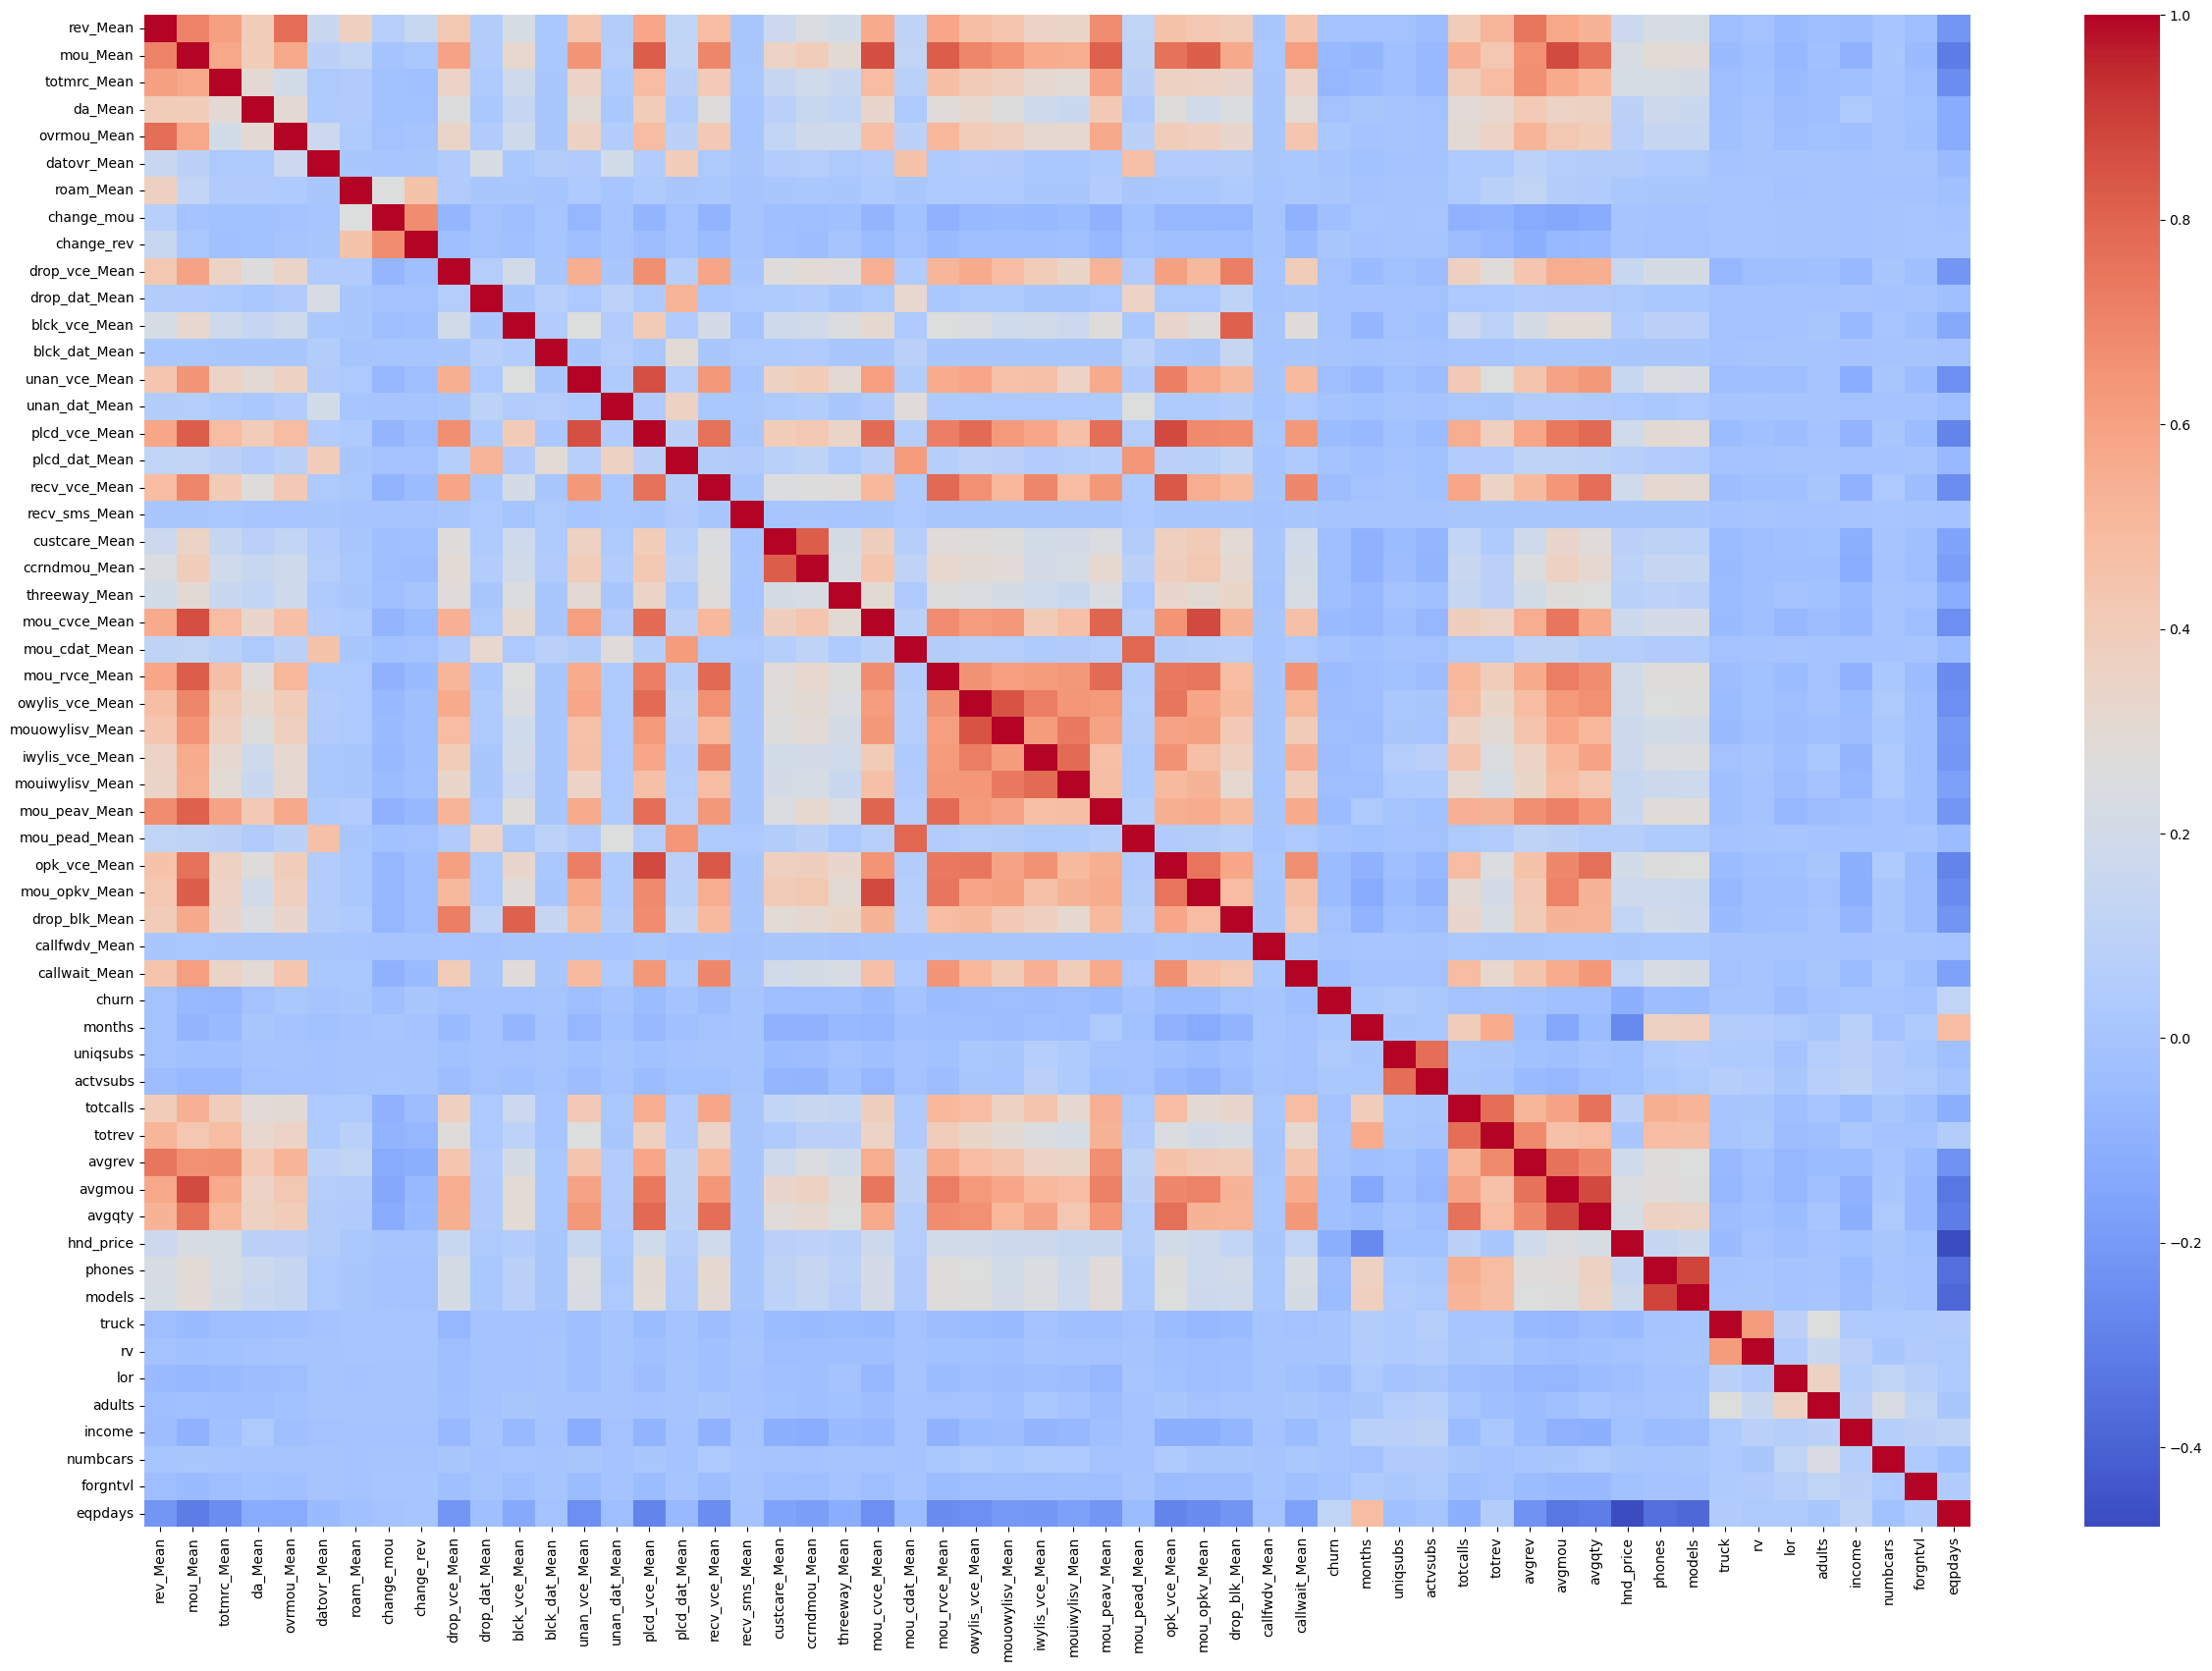

In [16]:
plt.figure(figsize=(30,20))
sns.heatmap(telco.corr(), cmap='coolwarm',annot=False);

In [17]:
telco = telco.drop('dwlltype', axis=1)

In [18]:
cat_cols = [col for col in telco.columns if telco[col].dtype=='object']
num_cols = [col for col in telco.columns if telco[col].dtype!='object']

In [19]:
telco[cat_cols].describe(include=['O']).T

,count,unique,top,freq
new_cell,100000,3,U,66914
crclscod,100000,54,AA,36509
asl_flag,100000,2,N,86064
prizm_social_one,92612,5,S,32097
area,99960,19,NEW YORK CITY AREA,11098
dualband,99999,4,Y,72265
refurb_new,99999,2,N,85593
hnd_webcap,89811,3,WCMB,75733
ownrent,66294,2,O,64284
marital,98268,5,U,37333


In [20]:
# Frequency Encoding

def frequency_encoder(cat_cols, df):
  for col in cat_cols:
    if col in df.columns:
      df= df.join(df[col].map(df[col].value_counts(normalize=True)).to_frame().add_suffix('_freq'))
  return df

In [21]:
telco = frequency_encoder(cat_cols, telco)
telco = telco.drop(cat_cols, axis=1)

In [22]:
telco.shape

(100000, 76)

In [23]:
# Memory Reduction
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [24]:
import gc

telco = reduce_mem_usage(telco)
gc.collect()

Mem. usage decreased to 14.40 Mb (75.2% reduction)


13053

In [25]:
# Iterative Imputer default=BayesianRidge()

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

idf = telco.copy()

imp_median = IterativeImputer(missing_values=np.nan, initial_strategy='median', random_state=42)
df_imputed_bayesian = pd.DataFrame(imp_median.fit_transform(idf), index=idf.index, columns=idf.columns)
null_values(df_imputed_bayesian)

,Missing_Records,Percentage (%)


In [26]:
telco = df_imputed_bayesian.copy()

In [27]:
def stripplot(regex, figsize, nrow=10, ncolumn = 4, target='churn', df=pd.DataFrame()):
  plt.figure(figsize=figsize)

  columns=[col for col in df.columns if re.search(regex, col)]

  for i,col in enumerate(columns):
      plt.subplot(nrow,ncolumn,i+1)
      sns.stripplot(y=df[col], data= df, x=target)

In [28]:
def outliers(s):
  # summary of the outliers
  iqr = (np.quantile(s, 0.75))-(np.quantile(s, 0.25))
  upper_bound = np.quantile(s, 0.75)+(1.5*iqr)
  lower_bound = np.quantile(s, 0.25)-(1.5*iqr)
  f = []
  for i in s:
      if i > upper_bound:
          f.append(i)
      elif i < lower_bound:
          f.append(i)
  sums = len(f)
  pros = len(f)/len(s)*100
  d = {'IQR':iqr,
        'Upper Bound':upper_bound,
      'Lower Bound':lower_bound,
      'Sum outliers': sums,'percentage outliers':pros}
  d = pd.DataFrame(d.items(),columns = ['sub','values'])
  return(d)


In [29]:
def plot_feature_importances(model, num=10, figsize=(20,10)):
  feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
  plt.figure(figsize=figsize)
  sns.barplot(x=feature_imp, y=feature_imp.index)
  plt.title("Feature Importance")
  plt.show()

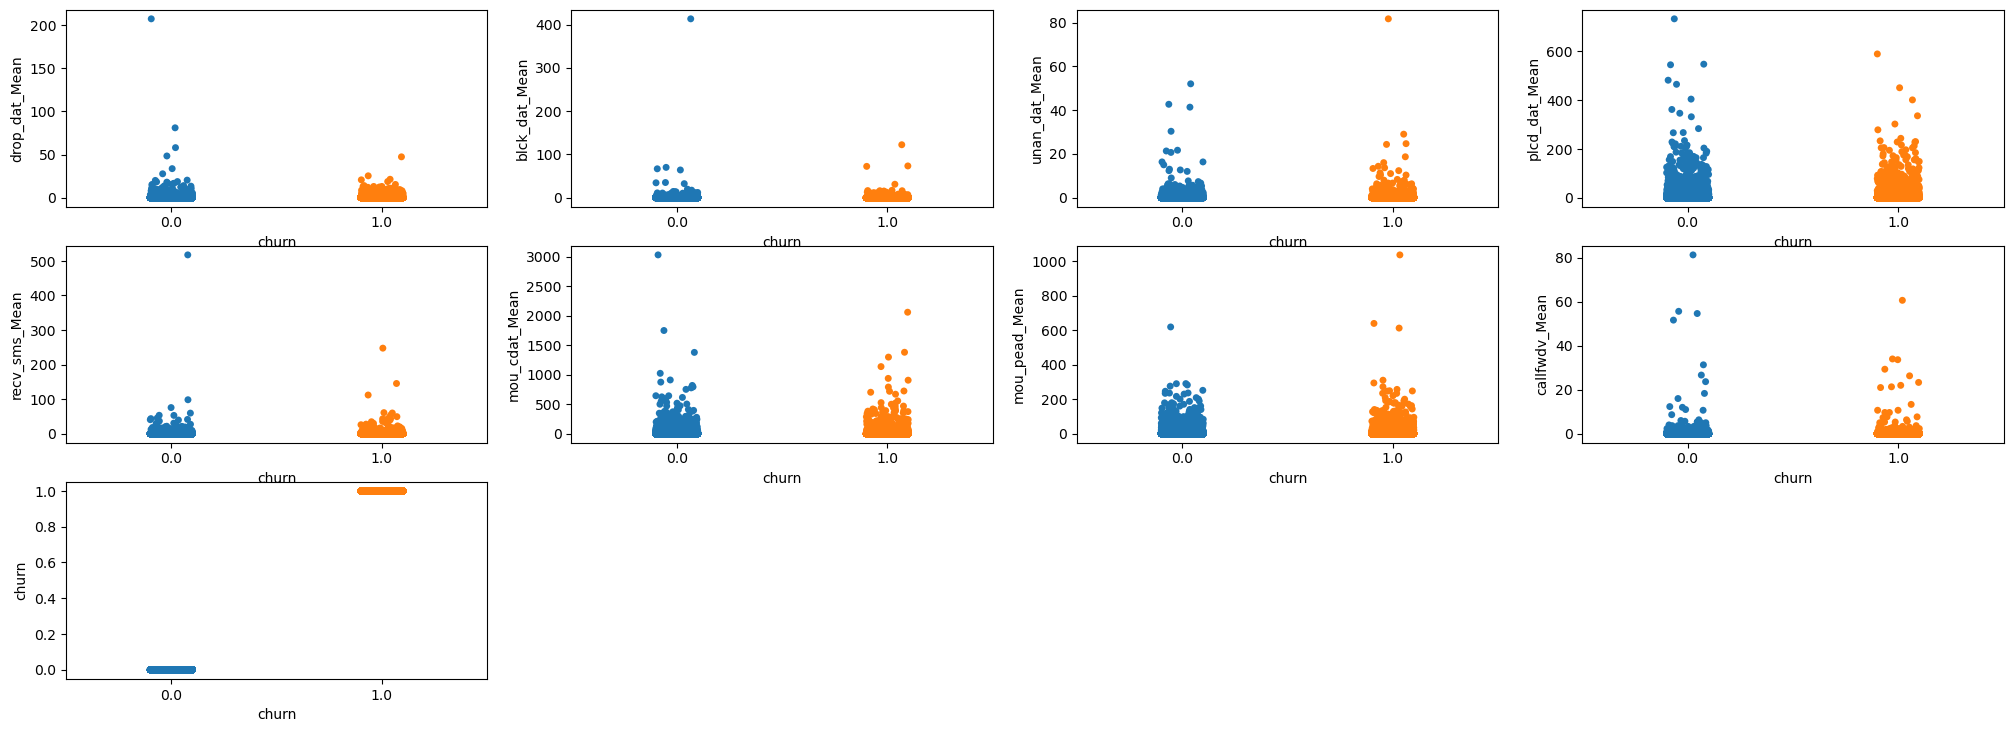

In [30]:
outliers_cols= ['drop_dat_Mean','blck_dat_Mean', 
               'unan_dat_Mean', 'plcd_dat_Mean','recv_sms_Mean', 
               'mou_cdat_Mean','mou_pead_Mean','callfwdv_Mean','churn']

stripplot('', figsize=(25,70), nrow=23, ncolumn = 4, target='churn', df=telco[outliers_cols])

In [31]:
outliers_cols.remove('churn')
for col in outliers_cols:
  telco[col] = telco[col].replace({telco[col].max():telco[col].median()})
  telco[col] = telco[col].replace({telco[col].max():telco[col].median()})
  telco[col] = telco[col].replace({telco[col].max():telco[col].median()})

In [32]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, scale, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import confusion_matrix, roc_curve, classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import multiprocessing
from IPython.core.pylabtools import figsize
font_title = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 100

In [33]:

lgb = LGBMClassifier(learning_rate= 0.05, 
                    max_depth= 12, 
                    n_estimators= 1000, 
                    subsample= 0.1)

rfe = RFECV(estimator=lgb, step=10, cv=KFold(n_splits=5, shuffle=False), scoring='accuracy', verbose=2)

X = telco.drop(['churn'], axis=1)
y = telco['churn']

rfe.fit(X, y)

Fitting estimator with 75 features.
Fitting estimator with 65 features.
Fitting estimator with 55 features.
Fitting estimator with 45 features.
Fitting estimator with 35 features.
Fitting estimator with 25 features.
Fitting estimator with 15 features.
Fitting estimator with 5 features.
Fitting estimator with 75 features.
Fitting estimator with 65 features.
Fitting estimator with 55 features.
Fitting estimator with 45 features.
Fitting estimator with 35 features.
Fitting estimator with 25 features.
Fitting estimator with 15 features.
Fitting estimator with 5 features.
Fitting estimator with 75 features.
Fitting estimator with 65 features.
Fitting estimator with 55 features.
Fitting estimator with 45 features.
Fitting estimator with 35 features.
Fitting estimator with 25 features.
Fitting estimator with 15 features.
Fitting estimator with 5 features.
Fitting estimator with 75 features.
Fitting estimator with 65 features.
Fitting estimator with 55 features.
Fitting estimator with 45 featu

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(learning_rate=0.05, max_depth=12,
                               n_estimators=1000, subsample=0.1),
      scoring='accuracy', step=10, verbose=2)

In [34]:
print('Optimal number of features:', rfe.n_features_)

Optimal number of features: 65


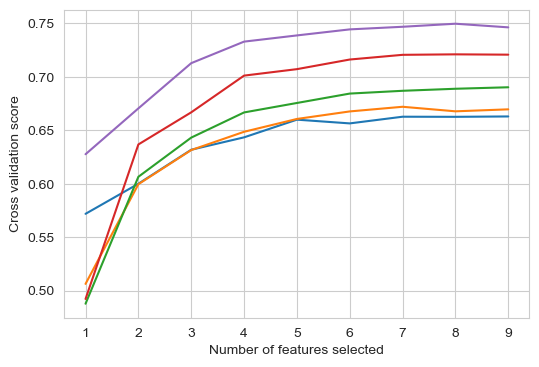

In [35]:
plt.figure(figsize=(6,4))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [36]:
rfecv_cols = [col for col in X.columns[rfe.ranking_ == 1]]
len(rfecv_cols)

65

In [37]:
rfecv_cols+=['churn']

In [38]:
telco[rfecv_cols].to_csv('rfecv.csv')

In [39]:
telco = pd.read_csv('rfecv.csv')

In [40]:
telco.head()

,Unnamed: 0,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,blck_vce_Mean,unan_vce_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,custcare_Mean,ccrndmou_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,mou_opkv_Mean,drop_blk_Mean,callwait_Mean,months,uniqsubs,actvsubs,totcalls,totrev,avgrev,avgmou,avgqty,hnd_price,phones,models,truck,rv,lor,adults,income,numbcars,eqpdays,new_cell_freq,crclscod_freq,asl_flag_freq,prizm_social_one_freq,area_freq,dualband_freq,hnd_webcap_freq,ownrent_freq,marital_freq,infobase_freq,HHstatin_freq,dwllsize_freq,ethnic_freq,kid0_2_freq,kid16_17_freq,creditcd_freq,churn
0,0,24.000000,219.25,22.500000,0.247559,0.00,0.0,0.0,-157.25,-19.0,0.666504,0.666504,6.332031,52.343750,0.0,42.343750,0.000000,0.000000,0.000000,90.625000,0.0,97.18750,0.000000,0.000000,0.000000,0.000000,132.625000,0.0,24.000000,55.218750,1.333008,0.333252,61.0,2.0,1.0,1652.0,1505.0,29.65625,83.37500,32.6875,150.000000,2.0,2.0,0.0,0.0,15.0,1.0,4.0,3.0,361.0,0.668945,0.169922,0.86084,0.346680,0.043304,0.722656,0.843262,0.969727,0.179321,0.99707,0.630371,0.765137,0.339844,0.958984,0.898438,0.684082,1.0
1,1,57.500000,482.75,37.437500,0.247559,22.75,0.0,0.0,532.00,51.0,8.335938,1.000000,61.343750,263.250000,0.0,69.000000,1.666992,6.332031,0.333252,189.375000,0.0,55.28125,46.343750,24.218750,6.332031,3.697266,75.312500,0.0,157.000000,169.375000,9.335938,5.667969,56.0,1.0,1.0,14654.0,2852.0,51.53125,479.50000,266.0000,82.210886,7.0,6.0,1.0,1.0,1.0,1.0,5.0,1.0,240.0,0.137817,0.064209,0.86084,0.254883,0.051422,0.231934,0.154175,0.958061,0.179321,0.99707,0.630371,0.765137,0.045044,0.958984,0.898438,0.684082,0.0
2,2,16.984375,10.25,16.984375,0.000000,0.00,0.0,0.0,-4.25,0.0,0.333252,0.000000,2.666016,9.000000,0.0,0.333252,0.000000,0.000000,0.000000,5.425781,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,5.191406,0.0,1.000000,0.233276,0.333252,0.000000,58.0,1.0,1.0,7903.0,2156.0,34.53125,434.00000,140.8750,29.984375,2.0,1.0,0.0,0.0,7.0,2.0,5.0,2.0,1504.0,0.192993,0.014557,0.86084,0.346680,0.046509,0.231934,0.061909,0.969727,0.315918,0.99707,0.630371,0.765137,0.339844,0.958984,0.898438,0.684082,1.0
3,3,38.000000,7.50,38.000000,0.000000,0.00,0.0,0.0,-1.50,0.0,0.000000,0.000000,0.000000,3.666016,0.0,1.333008,0.000000,0.000000,0.000000,8.406250,0.0,0.41333,0.333252,0.256592,0.000000,0.000000,3.380859,0.0,3.666016,5.449219,0.000000,0.000000,60.0,1.0,1.0,1502.0,2001.0,40.43750,63.21875,30.8125,29.984375,1.0,1.0,0.0,0.0,6.0,4.0,6.0,1.0,1812.0,0.192993,0.041107,0.86084,0.161865,0.051422,0.231934,-0.020631,0.881740,0.315918,0.99707,0.630371,0.012108,0.111389,0.040833,0.898438,0.684082,0.0
4,4,55.218750,570.50,72.000000,0.000000,0.00,0.0,0.0,38.50,0.0,9.664062,0.666504,77.000000,222.375000,0.0,94.687500,8.664062,15.000000,0.000000,285.250000,0.0,106.31250,14.664062,10.820312,0.666504,0.366699,173.500000,0.0,90.312500,218.125000,10.335938,0.000000,57.0,1.0,1.0,4485.0,2182.0,38.68750,249.37500,79.5000,150.000000,6.0,4.0,0.0,0.0,5.0,1.0,6.0,1.0,434.0,0.192993,0.169922,0.86084,0.254883,0.054535,0.722656,0.843262,0.030319,0.179321,0.99707,0.630371,0.018997,0.038788,0.958984,0.898438,0.684082,0.0


In [44]:
from sklearn.model_selection import train_test_split
X = telco.drop(['churn'], axis = 1)
Y = telco.churn


# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler

# Apply Standard Scaling only to the feature matrix (X_train and X_test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [45]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score

#1 Swish CNN Model
swish_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='swish', input_shape=(X_train_scaled.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='swish'),
    Dense(1, activation='sigmoid')
])
swish_cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Swish CNN Model
swish_cnn_model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1), Y_train, epochs=10,
                    batch_size=128)

# Swish CNN Model Predictions and Metrics
swish_cnn_predictions = swish_cnn_model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
swish_cnn_predictions_classes = (swish_cnn_predictions > 0.5).astype(int)
swish_cnn_accuracy = accuracy_score(Y_test, swish_cnn_predictions_classes)
swish_cnn_confusion = confusion_matrix(Y_test, swish_cnn_predictions_classes)
swish_cnn_classification_report = classification_report(Y_test, swish_cnn_predictions_classes)

print("Swish CNN Accuracy:", swish_cnn_accuracy)
print("Swish CNN Confusion Matrix:\n", swish_cnn_confusion)
print("Swish CNN Classification Report:\n", swish_cnn_classification_report)


Epoch 1/10
547/547 [==============================] - 12s 17ms/step - loss: 0.6717 - accuracy: 0.5849
Epoch 2/10
547/547 [==============================] - 9s 16ms/step - loss: 0.6625 - accuracy: 0.5982
Epoch 3/10
547/547 [==============================] - 8s 15ms/step - loss: 0.6581 - accuracy: 0.6056
Epoch 4/10
547/547 [==============================] - 9s 16ms/step - loss: 0.6548 - accuracy: 0.6101
Epoch 5/10
547/547 [==============================] - 9s 17ms/step - loss: 0.6513 - accuracy: 0.6131
Epoch 6/10
547/547 [==============================] - 9s 16ms/step - loss: 0.6481 - accuracy: 0.6188
Epoch 7/10
547/547 [==============================] - 8s 14ms/step - loss: 0.6431 - accuracy: 0.6243
Epoch 8/10
547/547 [==============================] - 8s 15ms/step - loss: 0.6358 - accuracy: 0.6351
Epoch 9/10
547/547 [==============================] - 8s 14ms/step - loss: 0.6189 - accuracy: 0.6543
Epoch 10/10
938/938 [==============================] - 3s 3ms/step
Swish CNN Accuracy: 0.6

In [ ]:
import matplotlib.pyplot as plt
#5 Light Gradient Boosting  (Individual Prediction)
LGBM = LGBMClassifier()
LGBM.fit(X_train_scaled, Y_train)

# Get feature importances
feature_imp = pd.Series(LGBM.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(18, 12))
sns.barplot(x=feature_imp[:50], y=feature_imp[:50].index)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

LGBM_predictions = LGBM.predict(X_test_scaled)
# LGBM (Cross-validation)
LGBM_cv = LGBMClassifier(learning_rate= 0.05, 
                    max_depth= 6, 
                    n_estimators= 1500, 
                    subsample= 0.1)
scores = cross_validate(LGBM_cv, X_train_scaled, Y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
accuracy_mean = np.mean(scores['test_accuracy'])
precision_mean = np.mean(scores['test_precision'])
recall_mean = np.mean(scores['test_recall'])
f1_mean = np.mean(scores['test_f1'])
auc_mean = np.mean(scores['test_roc_auc'])

print("LGBM (CV) Accuracy:", accuracy_mean)
print("LGBM (CV) Precision:", precision_mean)
print("LGBM (CV) Recall:", recall_mean)
print("LGBM (CV) F1:", f1_mean)
print("LGBM (CV) AUC:", auc_mean)

In [53]:
from tcn import TCN
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Reshape input data to match TCN input shape
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)

# Define the input layer
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))


# Define the TCN architecture
tcn_output = TCN(nb_filters=128, kernel_size=3, nb_stacks=2, dilations=[1, 2, 4, 8, 16, 32])(input_layer)

# Output layer
output_layer = Dense(1, activation='sigmoid')(tcn_output)

# Build the model
tcn_model = Model(inputs=input_layer, outputs=output_layer)
tcn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
tcn_model.fit(X_train_scaled, Y_train, epochs=10, batch_size=32)
tcn_predictions = tcn_model.predict(X_test_scaled)
tcn_predictions_classes = (tcn_predictions > 0.5).astype(int)

# Evaluation metrics
accuracy = accuracy_score(Y_test, tcn_predictions_classes)
f1 = f1_score(Y_test, tcn_predictions_classes)
recall = recall_score(Y_test, tcn_predictions_classes)
precision = precision_score(Y_test, tcn_predictions_classes)
roc_auc = roc_auc_score(Y_test, tcn_predictions)

print("TCN Model Evaluation:")
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("ROC AUC:", roc_auc)

LGBM (CV) Accuracy: 0.7051428571428572
LGBM (CV) Precision: 0.7022116276760146
LGBM (CV) Recall: 0.7003147852900418
LGBM (CV) F1: 0.7012534534288042
LGBM (CV) AUC: 0.7893625801724744


In [47]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 8, 10, 12],
    'n_estimators': [500, 1000, 1500],
    'subsample': [0.1, 0.5, 1.0]
}

# Initialize the LGBMClassifier
lgbm = LGBMClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_scaled, Y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best estimator
best_lgbm = grid_search.best_estimator_

# Evaluate the best estimator using cross-validation
scores = cross_validate(best_lgbm, X_train_scaled, Y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
accuracy_mean = np.mean(scores['test_accuracy'])
precision_mean = np.mean(scores['test_precision'])
recall_mean = np.mean(scores['test_recall'])
f1_mean = np.mean(scores['test_f1'])
auc_mean = np.mean(scores['test_roc_auc'])

print("Best LGBM (CV) Accuracy:", accuracy_mean)
print("Best LGBM (CV) Precision:", precision_mean)
print("Best LGBM (CV) Recall:", recall_mean)
print("Best LGBM (CV) F1:", f1_mean)

print("Best LGBM (CV) AUC:", auc_mean)


Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1500, 'subsample': 0.1}
Best LGBM (CV) Accuracy: 0.7051428571428572
Best LGBM (CV) Precision: 0.7022116276760146
Best LGBM (CV) Recall: 0.7003147852900418
Best LGBM (CV) F1: 0.7012534534288042
Best LGBM (CV) AUC: 0.7893625801724744


In [62]:
from tcn import TCN
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Reshape input data to match TCN input shape
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)

# Define the input layer
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))


# Define the TCN architecture
tcn_output = TCN(nb_filters=128, kernel_size=3, nb_stacks=2, dilations=[1, 2, 4, 8, 16, 32])(input_layer)

# Output layer
output_layer = Dense(1, activation='sigmoid')(tcn_output)

# Build the model
tcn_model = Model(inputs=input_layer, outputs=output_layer)
tcn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
tcn_model.fit(X_train_scaled, Y_train, epochs=10, batch_size=32)
tcn_predictions = tcn_model.predict(X_test_scaled)
tcn_predictions_classes = (tcn_predictions > 0.5).astype(int)

# Evaluation metrics
accuracy = accuracy_score(Y_test, tcn_predictions_classes)
f1 = f1_score(Y_test, tcn_predictions_classes)
recall = recall_score(Y_test, tcn_predictions_classes)
precision = precision_score(Y_test, tcn_predictions_classes)
roc_auc = roc_auc_score(Y_test, tcn_predictions)

print("TCN Model Evaluation:")
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("ROC AUC:", roc_auc)

Epoch 1/10
2188/2188 [==============================] - 1582s 715ms/step - loss: 0.9766 - accuracy: 0.5661
Epoch 2/10
2188/2188 [==============================] - 1567s 716ms/step - loss: 0.6467 - accuracy: 0.6169
Epoch 3/10
2188/2188 [==============================] - 1554s 710ms/step - loss: 0.5877 - accuracy: 0.6558
Epoch 4/10
2188/2188 [==============================] - 1571s 718ms/step - loss: 0.5561 - accuracy: 0.6749
Epoch 5/10
2188/2188 [==============================] - 1580s 722ms/step - loss: 0.5409 - accuracy: 0.6881
Epoch 6/10
2188/2188 [==============================] - 1565s 715ms/step - loss: 0.5287 - accuracy: 0.6978
Epoch 7/10
2188/2188 [==============================] - 1582s 723ms/step - loss: 0.5223 - accuracy: 0.6997
Epoch 8/10
2188/2188 [==============================] - 1575s 720ms/step - loss: 0.5120 - accuracy: 0.7076
Epoch 9/10
2188/2188 [==============================] - 1624s 742ms/step - loss: 0.5059 - accuracy: 0.7139
Epoch 10/10
938/938 [================

In [57]:
from tcn import TCN
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define the TCN model using a function
def create_tcn_model():
    input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
    tcn_output = TCN()(input_layer)  # You can use default values initially
    output_layer = Dense(1, activation='sigmoid')(tcn_output)
    tcn_model = Model(inputs=input_layer, outputs=output_layer)
    tcn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return tcn_model

# Create a KerasClassifier wrapper for the TCN model
tcn_classifier = KerasClassifier(build_fn=create_tcn_model)

# Define the parameter grid for GridSearchCV
param_grid = {
    'nb_filters': [32, 64, 128],
    'kernel_size': [2, 3, 4],
    'nb_stacks': [1, 2, 3],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Initialize GridSearchCV with the KerasClassifier wrapper
grid_search = GridSearchCV(tcn_classifier, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train_reshaped, Y_train)

# Get the best estimator
best_tcn_model = grid_search.best_estimator_

# Evaluate the best model using cross-validation
scores = cross_val_score(best_tcn_model, X_train_reshaped, Y_train, cv=5, scoring='accuracy')
mean_accuracy = np.mean(scores)

print("Best TCN Model:", best_tcn_model)
print("Mean Accuracy:", mean_accuracy)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


ValueError: kernel_size is not a legal parameter

In [58]:
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_transformer import Transformer

# Define the input layer
input_layer = Input(shape=(X_train_scaled.shape[1],))

# Define the Transformer architecture
transformer_output = Transformer(
    num_heads=4, num_layers=2, num_positions=num_features,
    embedding_dropout=0.2, attention_dropout=0.2, filter_size=64,
    inner_activation='relu', outer_activation='relu'
)([input_layer, input_layer])

# Add some fully connected layers
x = Dense(128, activation='relu')(transformer_output)
x = Dropout(0.2)(x)
x = LayerNormalization()(x)

# Output layer
output_layer = Dense(1, activation='sigmoid')(x)

# Build the model
transformer_model = Model(inputs=input_layer, outputs=output_layer)
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
transformer_model.fit(X_train_scaled, Y_train, epochs=10, batch_size=32)


ImportError: cannot import name 'Transformer' from 'keras_transformer' (C:\Users\User\AppData\Roaming\Python\Python39\site-packages\keras_transformer\__init__.py)